# Comparing stream power and nonlinear diffusion process models at Eightmile Lake, AK

## Inputs: Eightmile Lake DEM at 2m resolution, clipped to a 15km square buffer
## Components:
### Part 1) Space, FlowAccumulator, DepressionFinderAndRouter, FastscapeEroder
### Part 2) DepthDependentDiffuser, ExponentialWeatherer
## Outputs: Soil depth, Change in topographic elevation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from landlab import RasterModelGrid
from landlab.plot import imshow_grid
from landlab.components import Space, FlowAccumulator, DepressionFinderAndRouter, FastscapeEroder
from landlab.components import DepthDependentDiffuser, ExponentialWeatherer

/home/egp/.virtualenvs/landlab/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Step 1) Import the DEM, resampling to 30m resolution

In [2]:
current = 2 # meters per pixel
target = 30 # meters per pixel
scale = current / target

with rio.open('./gis/projects/dem/eightmile-lake-15km-buffer.tif') as src:

    # resample data to target shape
    data = src.read(
        out_shape = (
            src.count,
            int(src.height * scale),
            int(src.width * scale)
        ),
        resampling = rio.enums.Resampling.bilinear
    )

    # scale image transform
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )

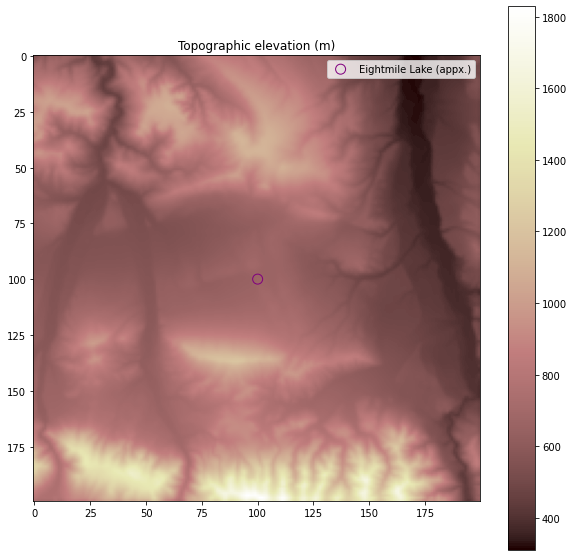

In [3]:
dem = np.flip(np.transpose(data[0]), 0)

fig, ax = plt.subplots(figsize = (10, 10))

im = plt.imshow(dem, cmap = 'pink')
plt.scatter(dem.shape[0] / 2, dem.shape[1] / 2, s = 100, color = 'purple', facecolors = 'none', label = 'Eightmile Lake (appx.)')
plt.legend()
plt.colorbar(im)
plt.title('Topographic elevation (m)')
plt.show()

## Step 2) Set up the model grid

In [4]:
grid = RasterModelGrid([dem.shape[0], dem.shape[1]])

In [5]:
grid.add_field('topographic__elevation', np.flip(dem.astype(float), 0), at = 'node', clobber = True)
grid.add_zeros('soil__depth', at = 'node', clobber = True)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [6]:
grid.set_closed_boundaries_at_grid_edges(
    bottom_is_closed = True,
    top_is_closed = False,
    right_is_closed = False,
    left_is_closed = False
)

## Step 3) Burn a stream network with FastscapeEroder

In [7]:
fast_dt = 100
FA = FlowAccumulator(grid, flow_director = 'D8')
DF = DepressionFinderAndRouter(grid, routing = 'D8')
FE = FastscapeEroder(grid, K_sp = 0.001, m_sp = 0.5, n_sp = 1)

In [8]:
nt = 20
count = 0

for t in range(nt):
    FA.run_one_step()
    DF.map_depressions()
    FE.run_one_step(dt = fast_dt)
    
    count += 1
    if count % 5 == 0:
        print('Completed ' + str(count) + ' time steps.')

Completed 5 time steps.
Completed 10 time steps.
Completed 15 time steps.
Completed 20 time steps.


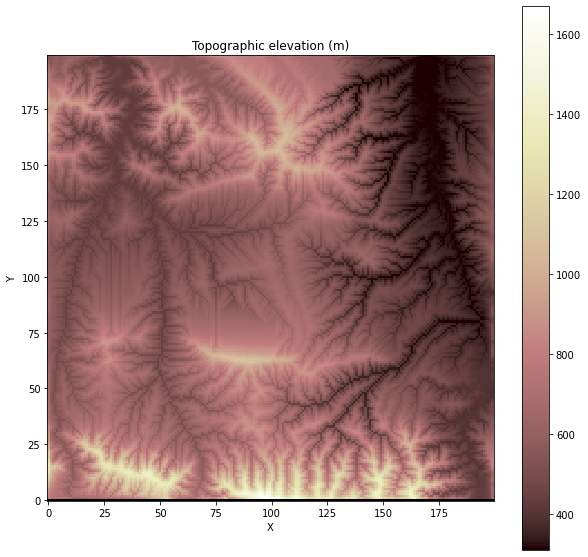

In [9]:
fig, ax = plt.subplots(figsize = (10, 10))

imshow_grid(grid, 'topographic__elevation')
plt.title('Topographic elevation (m)')
plt.show()

## Step 4) Set up the Space component

In [10]:
grid.at_node['soil__depth'] += 2.0
grid.at_node['topographic__elevation'] += grid.at_node['soil__depth']

In [11]:
SP = Space(grid)

In [12]:
nt = 5
space_dt = 10
count = 0
initial_topography = grid.at_node['topographic__elevation'].copy()

for t in range(nt):
    FA.run_one_step()
    DF.map_depressions()
    SP.run_one_step(dt = space_dt)
    
    count += 1
    if count < 5:
        print('Completed ' + str(count) + ' time steps.')
    if count % 5 == 0:
        print('Completed ' + str(count) + ' time steps.')

Completed 1 time steps.
Completed 2 time steps.
Completed 3 time steps.
Completed 4 time steps.
Completed 5 time steps.


In [13]:
grid.at_node.keys()

['topographic__elevation',
 'soil__depth',
 'water__unit_flux_in',
 'drainage_area',
 'flow__data_structure_delta',
 'flow__upstream_node_order',
 'surface_water__discharge',
 'flow__sink_flag',
 'flow__link_to_receiver_node',
 'flow__receiver_node',
 'topographic__steepest_slope',
 'depression__depth',
 'depression__outlet_node',
 'is_pit',
 'flood_status_code',
 'sediment__flux',
 'bedrock__elevation']

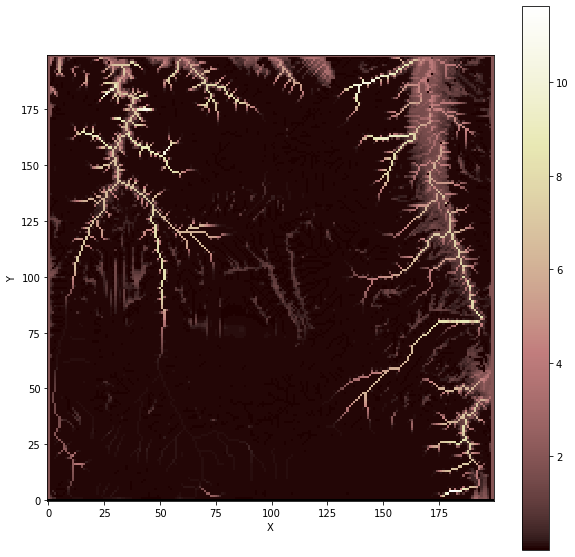

In [14]:
fig, ax = plt.subplots(figsize = (10, 10))
imshow_grid(grid, 'soil__depth')
plt.show()

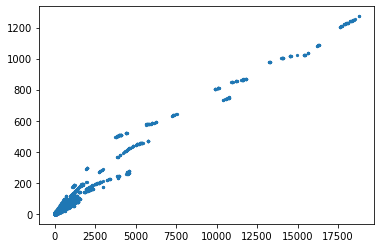

In [15]:
plt.scatter(grid.at_node['surface_water__discharge'][grid.core_nodes], grid.at_node['sediment__flux'][grid.core_nodes], s = 5)
plt.show()

## Step 5) Set up nonlinear diffusion component

In [16]:
grid = RasterModelGrid([dem.shape[0], dem.shape[1]])

In [17]:
grid.add_field('topographic__elevation', np.flip(dem.astype(float), 0), at = 'node', clobber = True)
grid.add_zeros('soil__depth', at = 'node', clobber = True)
grid.at_node['soil__depth'] += 2.0
grid.add_zeros('bedrock__elevation', at = 'node', clobber = True)
grid.at_node['bedrock__elevation'] = grid.at_node['topographic__elevation'] - grid.at_node['soil__depth']

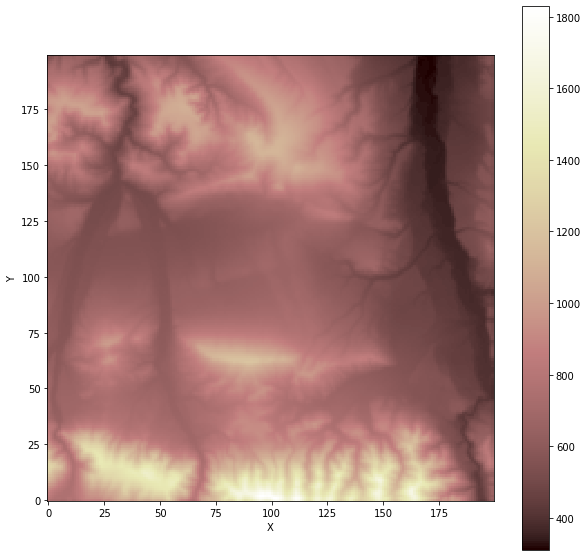

In [18]:
fig, ax = plt.subplots(figsize = (10, 10))
imshow_grid(grid, 'topographic__elevation')
plt.show()

In [19]:
EW = ExponentialWeatherer(grid, soil_production__maximum_rate = 0.01)
DD = DepthDependentDiffuser(grid, linear_diffusivity = 0.01)

initial_topo = grid.at_node['topographic__elevation'][:].copy()

In [20]:
nt = 100
dt = 10
count = 0

for i in range(nt):
    EW.calc_soil_prod_rate()
    DD.run_one_step(dt)
    
    count += 1
    if count % 5 == 0:
        print('Completed ' + str(count) + ' time steps.')

Completed 5 time steps.
Completed 10 time steps.
Completed 15 time steps.
Completed 20 time steps.
Completed 25 time steps.
Completed 30 time steps.
Completed 35 time steps.
Completed 40 time steps.
Completed 45 time steps.
Completed 50 time steps.
Completed 55 time steps.
Completed 60 time steps.
Completed 65 time steps.
Completed 70 time steps.
Completed 75 time steps.
Completed 80 time steps.
Completed 85 time steps.
Completed 90 time steps.
Completed 95 time steps.
Completed 100 time steps.


In [21]:
grid.at_node.keys()

['topographic__elevation',
 'soil__depth',
 'bedrock__elevation',
 'soil_production__rate']

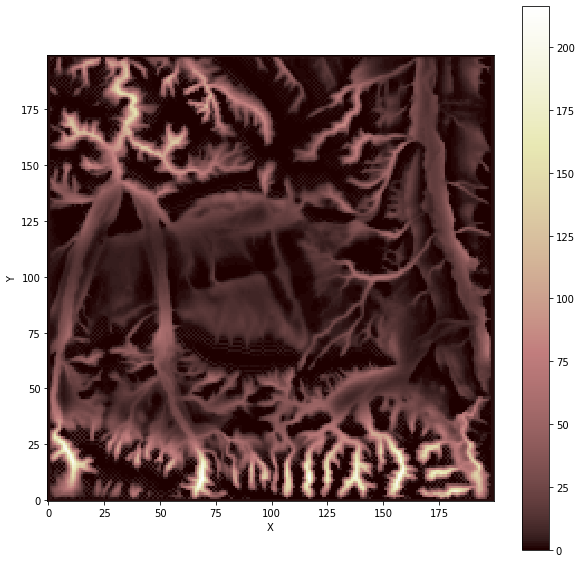

In [22]:
fig, ax = plt.subplots(figsize = (10, 10))
imshow_grid(grid, 'soil__depth')
plt.show()

In [23]:
grad = grid.calc_grad_at_link('bedrock__elevation')
slope = grid.map_mean_of_links_to_node(np.abs(grad))

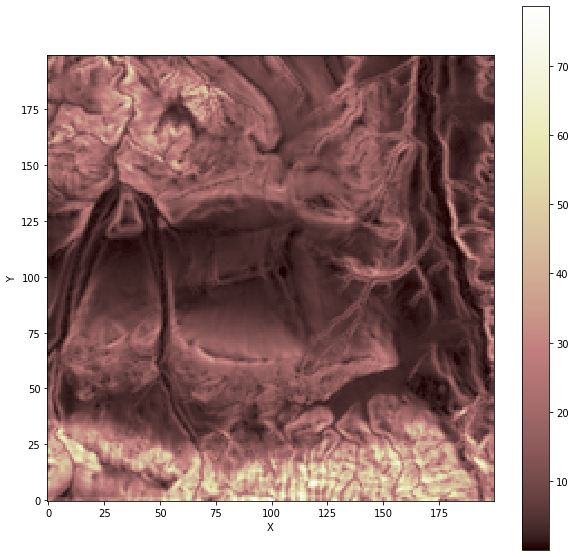

In [24]:
fig, ax = plt.subplots(figsize = (10, 10))
imshow_grid(grid, slope)
plt.show()

In [25]:
curvature_links = grid.calc_grad_at_link(slope)
curvature = grid.map_mean_of_links_to_node(curvature_links)

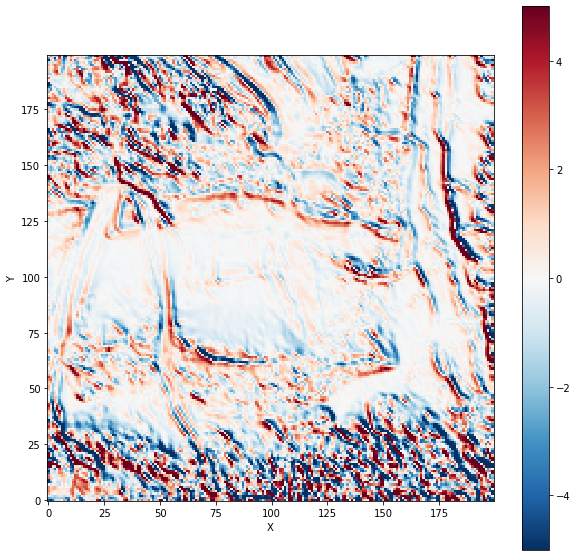

In [26]:
fig, ax = plt.subplots(figsize = (10, 10))
imshow_grid(grid, curvature, cmap = 'RdBu_r', vmin = -5, vmax = 5)
plt.show()

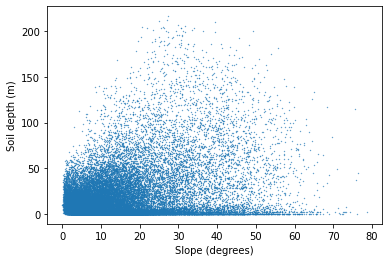

In [27]:
plt.scatter(slope, grid.at_node['soil__depth'], s = 0.1)
plt.xlabel('Slope (degrees)')
plt.ylabel('Soil depth (m)')
plt.show()

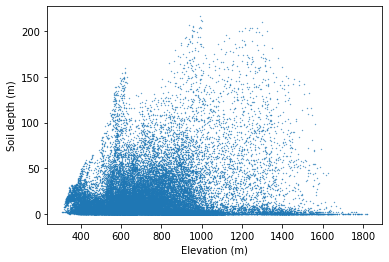

In [28]:
plt.scatter(grid.at_node['topographic__elevation'], grid.at_node['soil__depth'], s = 0.1)
plt.xlabel('Elevation (m)')
plt.ylabel('Soil depth (m)')
plt.show()

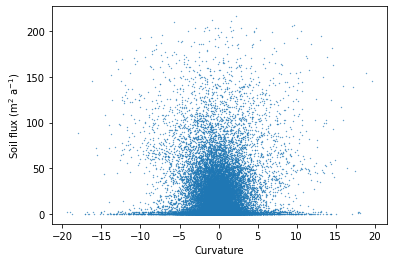

In [29]:
plt.scatter(curvature, grid.at_node['soil__depth'], s = 0.1)
plt.xlabel('Curvature')
plt.ylabel('Soil flux (m$^2$ a$^{-1}$)')
plt.show()

## Step 6) Combine diffusive and fluvial processes

In [30]:
grid = RasterModelGrid([dem.shape[0], dem.shape[1]])

In [31]:
grid.add_field('topographic__elevation', np.flip(dem.astype(float), 0), at = 'node', clobber = True)
grid.add_zeros('soil__depth', at = 'node', clobber = True)
grid.at_node['soil__depth'] += 2.0
grid.add_zeros('bedrock__elevation', at = 'node', clobber = True)
grid.at_node['bedrock__elevation'] = grid.at_node['topographic__elevation'] - grid.at_node['soil__depth']

In [32]:
grid.set_closed_boundaries_at_grid_edges(
    bottom_is_closed = True,
    top_is_closed = False,
    right_is_closed = False,
    left_is_closed = False
)

In [33]:
fast_dt = 100
FA = FlowAccumulator(grid, flow_director = 'D8')
DF = DepressionFinderAndRouter(grid, routing = 'D8')
FE = FastscapeEroder(grid, K_sp = 0.001, m_sp = 0.5, n_sp = 1)

In [34]:
nt = 20
count = 0

for t in range(nt):
    FA.run_one_step()
    DF.map_depressions()
    FE.run_one_step(dt = fast_dt)
    
    count += 1
    if count % 5 == 0:
        print('Completed ' + str(count) + ' time steps.')

Completed 5 time steps.
Completed 10 time steps.
Completed 15 time steps.
Completed 20 time steps.


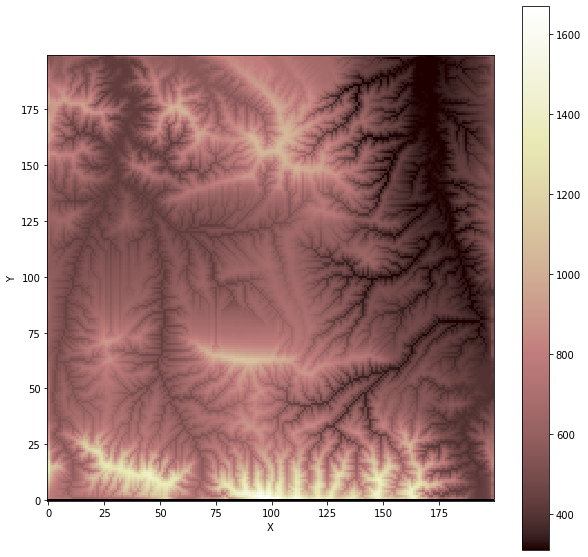

In [35]:
fig, ax = plt.subplots(figsize = (10, 10))
imshow_grid(grid, 'topographic__elevation')
plt.show()

In [36]:
EW = ExponentialWeatherer(grid, soil_production__maximum_rate = 0.01)
DD = DepthDependentDiffuser(grid, linear_diffusivity = 0.01)
SP = Space(grid)

initial_topography = grid.at_node['topographic__elevation'].copy()

In [37]:
FA.run_one_step()

In [38]:
DF.map_depressions()

In [39]:
SP.run_one_step(1)

In [40]:
EW.calc_soil_prod_rate()

In [41]:
DD.run_one_step(1)

In [49]:
nt = 50
dt = 1
count = 0

for t in range(nt):
    FA.run_one_step()
    DF.map_depressions()
    SP.run_one_step(dt)
    
    EW.calc_soil_prod_rate()
    DD.run_one_step(dt)
        
    count += 1
    if count < 5:
        print('Completed ' + str(count) + ' time steps.')
    if count % 5 == 0:
        print('Completed ' + str(count) + ' time steps.')

Completed 1 time steps.
Completed 2 time steps.
Completed 3 time steps.
Completed 4 time steps.
Completed 5 time steps.
Completed 10 time steps.
Completed 15 time steps.
Completed 20 time steps.
Completed 25 time steps.
Completed 30 time steps.
Completed 35 time steps.
Completed 40 time steps.
Completed 45 time steps.
Completed 50 time steps.


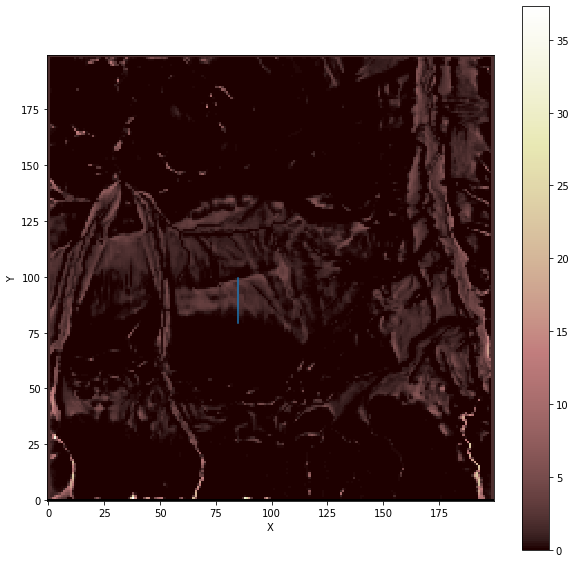

In [86]:
x = 85

fig, ax = plt.subplots(figsize = (10, 10))
imshow_grid(grid, 'soil__depth')
plt.axvline(x, ymin = 0.4, ymax = 0.5)
plt.show()

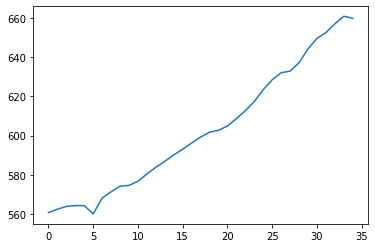

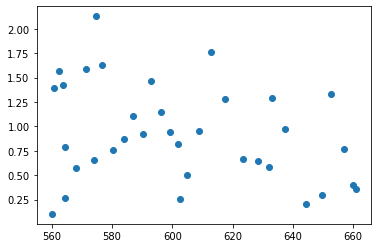

In [87]:
elevation = grid.node_vector_to_raster(grid.at_node['topographic__elevation'], flip_vertically = True)[x, 65:100]
soil = grid.node_vector_to_raster(grid.at_node['soil__depth'], flip_vertically = True)[x, 65:100]

plt.plot(elevation)
plt.show()

plt.scatter(elevation, soil)
plt.show()